
Testing SPF policy...

Step 0 Achievable Goals:

SPF - Step 0
Current state: {(0, 1): 0, (1, 2): 0, (2, 3): 0, (3, 4): -1}
Current EDRs: {(0, 4): 0.0, (2, 4): 0.0}
Success Rates: {(0, 4): 0.0, (2, 4): 0.0}
Attempt Counts: {(0, 4): 0, (2, 4): 0}

Step 1000 Achievable Goals:
Goal: (0, 4), Path: [(0, 1), (1, 2), (2, 3), (3, 4)], Length: 4, EDR: 0.0000
Goal: (2, 4), Path: [(2, 3), (3, 4)], Length: 2, EDR: 0.5340

SPF - Step 1000
Current state: {(0, 1): 0, (1, 2): 1, (2, 3): 0, (3, 4): 0}
Current EDRs: {(0, 4): 0.0, (2, 4): 0.5344655344655345}
Success Rates: {(0, 4): 0.0, (2, 4): 0.8143074581430746}
Attempt Counts: {(0, 4): 0, (2, 4): 657}

Step 2000 Achievable Goals:

SPF - Step 2000
Current state: {(0, 1): 0, (1, 2): 1, (2, 3): 0, (3, 4): 0}
Current EDRs: {(0, 4): 0.0, (2, 4): 0.5442278860569715}
Success Rates: {(0, 4): 0.0, (2, 4): 0.8114754098360656}
Attempt Counts: {(0, 4): 0, (2, 4): 1342}

Step 3000 Achievable Goals:
Goal: (0, 4), Path: [(0, 1), (1, 2), (2, 3), (3, 4)], Length: 4, E

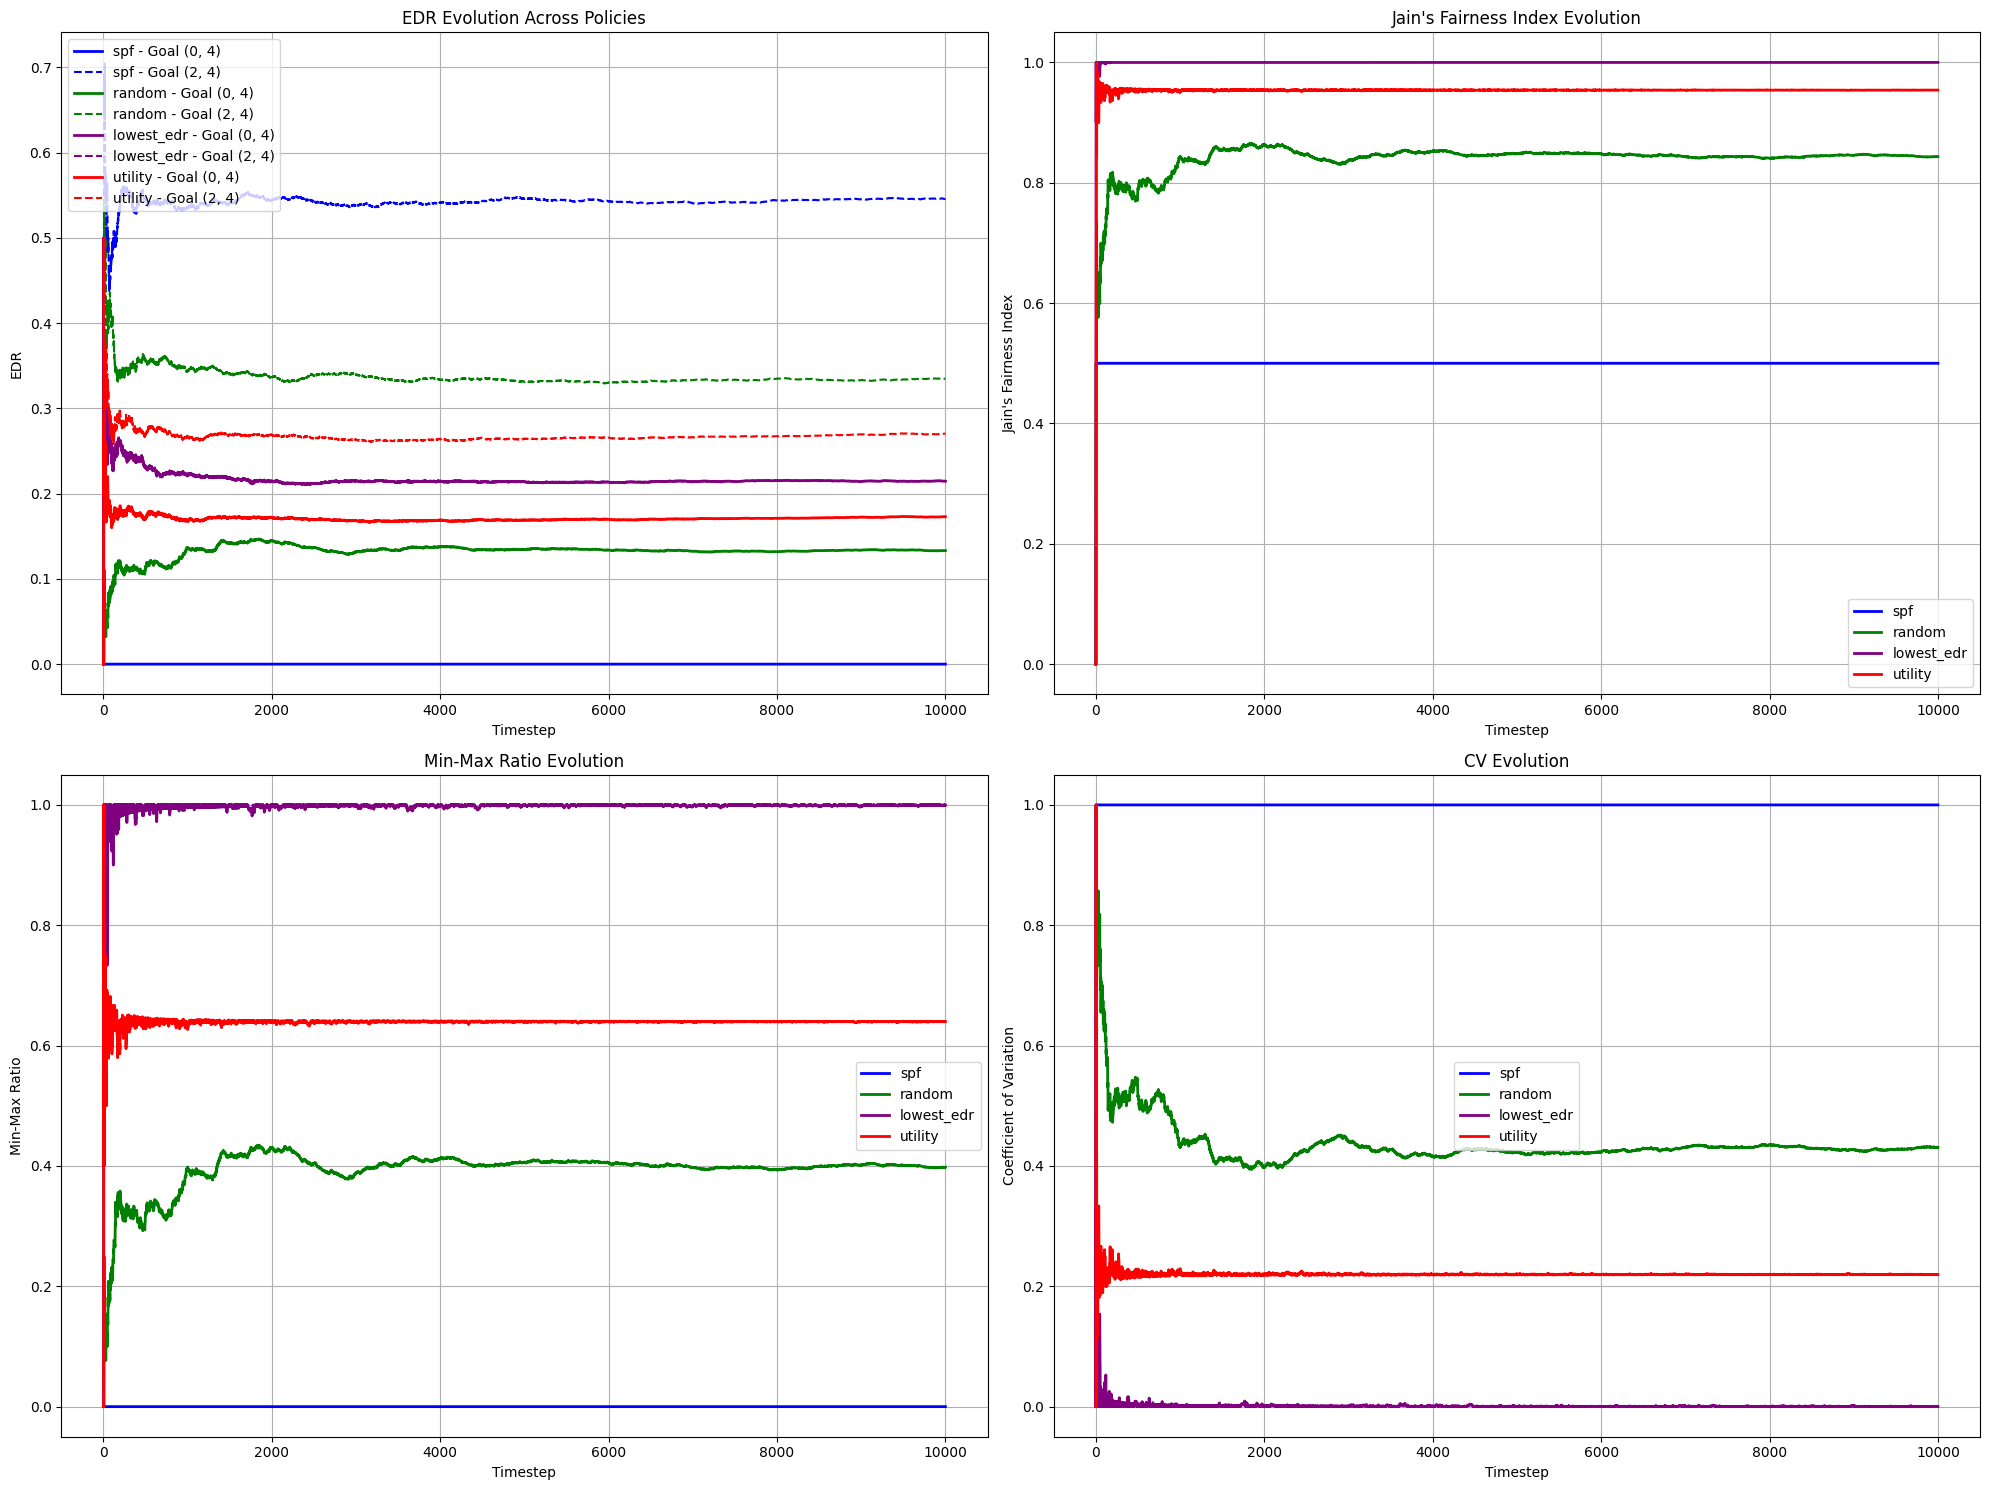


=== Final Statistics ===
Parameters: pSwap=0.8, pGen=0.8, maxAge=2
Network: edges=[(0, 1), (1, 2), (2, 3), (3, 4)], goals=[(0, 4), (2, 4)]


SPF Policy Results:
Final EDRs:
Goal (0, 4): 0.000000
  Attempts: 0
  Successes: 0
  Success Rate: 0.0000
Goal (2, 4): 0.545800
  Attempts: 6828
  Successes: 5458
  Success Rate: 0.7994

Final Fairness Metrics:
Jain's Index: 0.5000
Min-Max Ratio: 0.0000
CV: 1.0000
Total successes: 5458
Total attempts: 6828
Overall success rate: 0.7994

RANDOM Policy Results:
Final EDRs:
Goal (0, 4): 0.133200
  Attempts: 2616
  Successes: 1332
  Success Rate: 0.5092
Goal (2, 4): 0.334800
  Attempts: 4188
  Successes: 3348
  Success Rate: 0.7994

Final Fairness Metrics:
Jain's Index: 0.8435
Min-Max Ratio: 0.3978
CV: 0.4308
Total successes: 4680
Total attempts: 6804
Overall success rate: 0.6878

LOWEST_EDR Policy Results:
Final EDRs:
Goal (0, 4): 0.214600
  Attempts: 4140
  Successes: 2146
  Success Rate: 0.5184
Goal (2, 4): 0.214700
  Attempts: 2675
  Successes: 21

In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from itertools import product, combinations

def find_path(start, end, state, edges):
    """Find path from start to end using BFS"""
    queue = [(start, [])]
    visited = set()
    
    while queue:
        current, path = queue.pop(0)
        if current == end:
            return path
        
        if current in visited:
            continue
        visited.add(current)
        
        # Try all possible next steps
        for edge in edges:
            s, e = edge
            # Check both directions of the edge
            if s == current and state[edge] >= 0:
                if e not in visited:
                    queue.append((e, path + [edge]))
            elif e == current and state[edge] >= 0:
                if s not in visited:
                    queue.append((s, path + [edge]))
    
    return None  # No path found

def calculate_fairness_metrics(edrs):
    """Calculate various fairness metrics for the given EDRs"""
    if not edrs:
        return 0, 0, 0
    
    values = list(edrs.values())
    
    # Jain's Fairness Index
    numerator = sum(values) ** 2
    denominator = len(values) * sum(x * x for x in values)
    jains_index = numerator / denominator if denominator != 0 else 0
    
    # Min-Max Ratio
    min_val = min(values)
    max_val = max(values)
    min_max_ratio = min_val / max_val if max_val != 0 else 0
    
    # Coefficient of Variation (CV)
    mean = np.mean(values)
    std = np.std(values)
    cv = std / mean if mean != 0 else 0
    
    return jains_index, min_max_ratio, cv

def get_achievable_goals(current_state, edges, goalEdges, goal_success_counts, total_timesteps):
    achievable = []
    
    for goal in goalEdges:
        start, end = goal
        path = find_path(start, end, current_state, edges)
        if path:
            current_edr = goal_success_counts[goal] / max(1, total_timesteps)
            achievable.append({
                'goal': goal,
                'path': path,
                'length': len(path),
                'edr': current_edr
            })
    return achievable

def choose_goal(achievable_goals, policy_type):
    if not achievable_goals:
        return None, None
        
    if policy_type == 'spf':
        # Choose the path with minimum length
        shortest = min(achievable_goals, key=lambda x: x['length'])
        return shortest['goal'], shortest['path']
    
    elif policy_type == 'random':
        # Randomly choose from available goals
        chosen = random.choice(achievable_goals)
        return chosen['goal'], chosen['path']
    
    elif policy_type == 'lowest_edr':
        # Choose the goal with lowest EDR (prioritize underserved goals)
        lowest = min(achievable_goals, 
                    key=lambda x: x['edr'] if x['edr'] > 0 else float('-inf'))
        return lowest['goal'], lowest['path']
    
    elif policy_type == 'utility':
        # Calculate utility for each goal using instant_rate/edr (same as Q-learning)
        def calculate_utility(goal_info):
            instant_rate = pSwap ** (goal_info['length'] - 1)
            edr = max(0.0001, goal_info['edr'])
            return instant_rate / edr if instant_rate > 0 and edr > 0 else 0
            
        highest_utility = max(achievable_goals, key=calculate_utility)
        return highest_utility['goal'], highest_utility['path']
    
    return None, None

def attempt_swap(path, pSwap):
    """Attempt swap operation with probability based on path length"""
    num_swaps = len(path) - 1
    success_prob = pSwap ** num_swaps
    return random.random() < success_prob

def simulate_policy(edges, goalEdges, pSwap, pGen, maxAge, policy_type, num_steps=1000):
    total_timesteps = 0
    goal_success_counts = {goal: 0 for goal in goalEdges}
    goal_attempt_counts = {goal: 0 for goal in goalEdges}
    edr_history = {goal: [] for goal in goalEdges}
    fairness_history = {
        'jains_index': [],
        'min_max_ratio': [],
        'cv': []
    }
    
    # Initialize state
    current_state = {edge: -1 for edge in edges}
    
    for step in range(num_steps):
        # 1. Get all achievable goals first
        achievable_goals = get_achievable_goals(current_state, edges, goalEdges, 
                                              goal_success_counts, total_timesteps)
        
        # Debug print for achievable goals
        if step % 1000 == 0:
            print(f"\nStep {step} Achievable Goals:")
            for g in achievable_goals:
                print(f"Goal: {g['goal']}, Path: {g['path']}, Length: {g['length']}, EDR: {g['edr']:.4f}")
        
        # 2. Choose and attempt swaps
        if achievable_goals:
            chosen_goal, chosen_path = choose_goal(achievable_goals, policy_type)
            
            if chosen_goal and chosen_path:
                goal_attempt_counts[chosen_goal] += 1
                # Attempt the swap
                if attempt_swap(chosen_path, pSwap):
                    goal_success_counts[chosen_goal] += 1
                # Consume entanglements regardless of success
                for edge in chosen_path:
                    current_state[edge] = -1
        
        # 3. Age existing entanglement
        for edge in edges:
            if current_state[edge] >= 0:
                current_state[edge] += 1
                if current_state[edge] >= maxAge:
                    current_state[edge] = -1
        
        # 4. Generate new entanglement
        for edge in edges:
            if current_state[edge] == -1 and random.random() < pGen:
                current_state[edge] = 0
        
        total_timesteps += 1
        
        # Update histories
        current_edrs = {goal: goal_success_counts[goal] / total_timesteps 
                       for goal in goalEdges}
        for goal in goalEdges:
            edr_history[goal].append(current_edrs[goal])
        
        # Calculate and store fairness metrics
        jains, minmax, cv = calculate_fairness_metrics(current_edrs)
        fairness_history['jains_index'].append(jains)
        fairness_history['min_max_ratio'].append(minmax)
        fairness_history['cv'].append(cv)
        
        if step % 1000 == 0:
            print(f"\n{policy_type.upper()} - Step {step}")
            print(f"Current state: {current_state}")
            print(f"Current EDRs: {current_edrs}")
            print("Success Rates:", {
                goal: goal_success_counts[goal]/max(1, goal_attempt_counts[goal]) 
                for goal in goalEdges
            })
            print("Attempt Counts:", goal_attempt_counts)
    
    return edr_history, fairness_history, goal_success_counts, goal_attempt_counts, total_timesteps

def plot_comparison_results(results, edges, goalEdges, pSwap, pGen, maxAge):
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # Define colors for each policy
    policy_colors = {
        'spf': 'blue',
        'random': 'green',
        'lowest_edr': 'purple',
        'utility': 'red'
    }
    
    # Plot EDR evolution
    for policy_name, result in results.items():
        color = policy_colors[policy_name]
        for i, goal in enumerate(goalEdges):
            linestyle = '-' if i == 0 else '--'
            linewidth = 2 if i == 0 else 1.5
            ax1.plot(result['edr_history'][goal], 
                    label=f'{policy_name} - Goal {goal}',
                    color=color,
                    linestyle=linestyle,
                    linewidth=linewidth)
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('EDR')
    ax1.set_title('EDR Evolution Across Policies')
    ax1.grid(True)
    ax1.legend()
    
    # Plot Jain's Fairness Index
    for policy_name, result in results.items():
        ax2.plot(result['fairness_history']['jains_index'], 
                label=f'{policy_name}',
                color=policy_colors[policy_name],
                linewidth=2)
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel("Jain's Fairness Index")
    ax2.set_title("Jain's Fairness Index Evolution")
    ax2.grid(True)
    ax2.legend()
    
    # Plot Min-Max Ratio
    for policy_name, result in results.items():
        ax3.plot(result['fairness_history']['min_max_ratio'], 
                label=f'{policy_name}',
                color=policy_colors[policy_name],
                linewidth=2)
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Min-Max Ratio')
    ax3.set_title('Min-Max Ratio Evolution')
    ax3.grid(True)
    ax3.legend()
    
    # Plot Coefficient of Variation
    for policy_name, result in results.items():
        ax4.plot(result['fairness_history']['cv'], 
                label=f'{policy_name}',
                color=policy_colors[policy_name],
                linewidth=2)
    ax4.set_xlabel('Timestep')
    ax4.set_ylabel('Coefficient of Variation')
    ax4.set_title('CV Evolution')
    ax4.grid(True)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print final statistics
    print("\n=== Final Statistics ===")
    print(f"Parameters: pSwap={pSwap}, pGen={pGen}, maxAge={maxAge}")
    print(f"Network: edges={edges}, goals={goalEdges}\n")
    
    for policy_name, result in results.items():
        print(f"\n{policy_name.upper()} Policy Results:")
        final_edrs = {goal: result['goals_achieved'][goal] / result['total_timesteps'] 
                     for goal in goalEdges}
        
        print("Final EDRs:")
        for goal in goalEdges:
            print(f"Goal {goal}: {final_edrs[goal]:.6f}")
            print(f"  Attempts: {result['goal_attempts'][goal]}")
            print(f"  Successes: {result['goals_achieved'][goal]}")
            success_rate = result['goals_achieved'][goal]/max(1, result['goal_attempts'][goal])
            print(f"  Success Rate: {success_rate:.4f}")
        
        jains, minmax, cv = calculate_fairness_metrics(final_edrs)
        print("\nFinal Fairness Metrics:")
        print(f"Jain's Index: {jains:.4f}")
        print(f"Min-Max Ratio: {minmax:.4f}")
        print(f"CV: {cv:.4f}")
        print(f"Total successes: {sum(result['goals_achieved'].values())}")
        print(f"Total attempts: {sum(result['goal_attempts'].values())}")
        overall_success = sum(result['goals_achieved'].values())/max(1, sum(result['goal_attempts'].values()))
        print(f"Overall success rate: {overall_success:.4f}")

edges = [(0, 1), (1,2), (2, 3), (3, 4)]
goalEdges = [(0, 4), (2, 4)]
pSwap = 0.8
pGen = 0.8
maxAge = 2
gamma = 0.99
epsilon = 0.001
max_iterations = 1000
temp = 1.0  # Temperature for softmax
num_steps = 10000
# Test all policies
policies = ['spf', 'random', 'lowest_edr', 'utility']
results = {}

for policy in policies:
    print(f"\nTesting {policy.upper()} policy...")
    edr_history, fairness_history, goals_achieved, goal_attempts, total_timesteps = simulate_policy(
        edges=edges,
        goalEdges=goalEdges,
        pSwap=pSwap,
        pGen=pGen,
        maxAge=maxAge,
        policy_type=policy,
        num_steps=num_steps
    )
    
    results[policy] = {
        'edr_history': edr_history,
        'fairness_history': fairness_history,
        'goals_achieved': goals_achieved,
        'goal_attempts': goal_attempts,
        'total_timesteps': total_timesteps
    }

# Plot and print comparison results
plot_comparison_results(results, edges, goalEdges, pSwap, pGen, maxAge)